# Import the necessary Packages

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import os
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torchsummary import summary
from sklearn.metrics import classification_report

print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu117
True


### Gravics card

In [2]:
! nvidia-smi

Sat May 13 12:01:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   68C    P3    N/A /  N/A |      6MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load the image

In [3]:
os.listdir()

['Testing.py',
 'Sign Language.zip',
 'Data Collection.py',
 'sign-languages.ipynb',
 '.ipynb_checkpoints',
 'Data Collection',
 'Data Collection.ipynb']

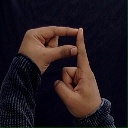

In [4]:
# Load image
image_dirs = os.path.join('Data Collection', 'Sign Language images')

img = Image.open(os.path.join(image_dirs+ '/P/0.jpg'))
img

In [5]:
# Convert image to NumPy array
img_array = np.array(img)

# Print array shape
print(img_array.shape)

(128, 128, 3)


In [6]:
# Image directory
data_dir   = pathlib.Path(image_dirs)

# List of all files in the directory and its subdirectories
image_path = list(data_dir.glob('*/*.jpg'))

# total number of image files
image_count = len(image_path)

# Unique labels
Labels = list(set(p.parent.name for p in image_path))
print('Labels :',sorted(Labels))
num_labels = len(Labels)

# Print the results
print(f"Found {image_count} images in {num_labels} unique labels")

Labels : ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Found 42000 images in 35 unique labels


# Preprocessing

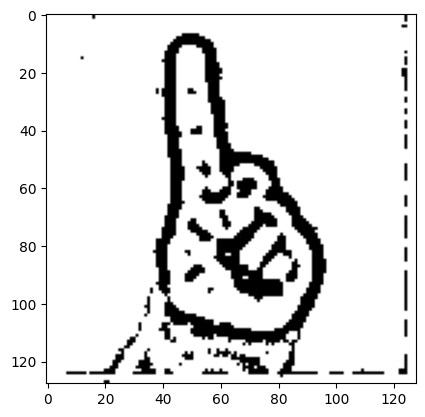

In [7]:
# Image Preprocessing
class Image_preprocessing():
    def __init__(self, minValue=70):
        #self.path = path
        self.minValue = minValue
    def image_preprocessing(self,img):
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(5, 5), 2)

        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        ret, res = cv2.threshold(th3, self.minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        return res

    def __call__(self, path):
        return self.image_preprocessing(path)

# Check
Path =os.path.join(image_dirs + '/1/0.jpg')
img_preprocessing = Image_preprocessing()
img =Image.open(Path)
plt.imshow(img_preprocessing(img),cmap='gray')
plt.show()

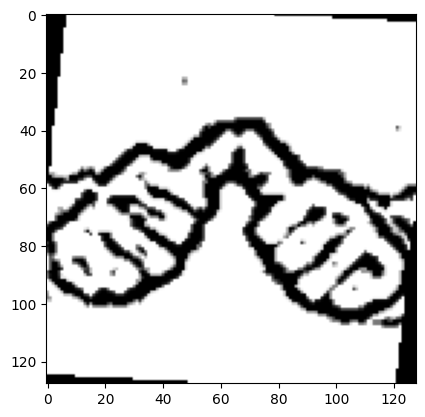

In [8]:
# Define the transforms to apply to the images
Transforms = transforms.Compose([
    Image_preprocessing(),
    transforms.ToPILImage(),
    # Random crop with zoom
    transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0), ratio=(0.8, 1.2)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=7),   # Rotate the image randomly up to 30 degrees
    transforms.RandomAffine(degrees=0, shear=7),   # Apply affine transformation with shear up to 30 degrees
    transforms.ToTensor(),    # Convert the image to a tensor
    transforms.Normalize(mean=[0.5],
                         std=[0.5])  # Normalize the pixel values
     
])

# Check
Path =os.path.join(image_dirs + '/A/0.jpg')
img =Image.open(Path)
img_transformed = Transforms(img)
img_transformed.shape

plt.imshow(img_transformed.permute(1, 2, 0), cmap='gray')
plt.show()

In [9]:
# ImageFolder dataset for the full dataset
full_dataset = datasets.ImageFolder(image_dirs, transform=Transforms)

# Split the dataset into training and testing sets
train_size = int(0.75 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = data.random_split(full_dataset, [train_size, test_size])

# Print the number of images in each set
print(f"Found {len(train_dataset)} images in the training set")
print(f"Found {len(test_dataset)} images in the testing set")

Found 31501 images in the training set
Found 10501 images in the testing set


In [10]:
# access the label with indices reverse the dictionay
# by key to value and value to key
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}
Labels_index

{0: '1',
 1: '2',
 2: '3',
 3: '4',
 4: '5',
 5: '6',
 6: '7',
 7: '8',
 8: '9',
 9: 'A',
 10: 'B',
 11: 'C',
 12: 'D',
 13: 'E',
 14: 'F',
 15: 'G',
 16: 'H',
 17: 'I',
 18: 'J',
 19: 'K',
 20: 'L',
 21: 'M',
 22: 'N',
 23: 'O',
 24: 'P',
 25: 'Q',
 26: 'R',
 27: 'S',
 28: 'T',
 29: 'U',
 30: 'V',
 31: 'W',
 32: 'X',
 33: 'Y',
 34: 'Z'}

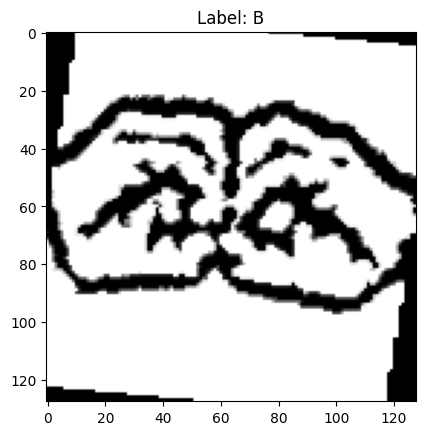

In [11]:
# Get the image and label from the dataset
index = 23000  # Change this to the index of the image you want to plot
image, label = train_dataset[index]

# Convert the image tensor to a numpy array and transpose it to the correct format
image = np.transpose(image.numpy(), (1, 2, 0))

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f"Label: {Labels_index[label]}")
plt.show()

# Build the Model

In [12]:
class Sign_Language(nn.Module):
    def __init__(self):
        super(Sign_Language, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 35)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = Sign_Language()

In [13]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU if available
model.to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Linear-13                  [-1, 512]      16,777,728
             ReLU-14                  [

In [14]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Define the data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  74299 KiB |  95175 KiB | 104470 KiB |  30171 KiB |
|       from large pool |  73856 KiB |  88192 KiB |  94336 KiB |  20480 KiB |
|       from small pool |    443 KiB |   6983 KiB |  10134 KiB |   9691 KiB |
|---------------------------------------------------------------------------|
| Active memory         |  74299 KiB |  95175 KiB | 104470 KiB |  30171 KiB |
|       from large pool |  73856 KiB |  88192 KiB |  94336 KiB |

In [17]:
num_epochs =5
# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    
    # Set the model to training mode
    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the training loss and accuracy
        train_loss += loss.item() * images.size(0)
        Max_val, pred_max_label =torch.max(outputs.data, 1)

     
        train_acc += (pred_max_label == labels).sum().item()            

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    
    # Evaluate the model on the test set
    test_loss = 0.0
    test_acc = 0.0
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Move the data to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Update the test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_acc += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_acc /= len(test_loader.dataset)
    # Free up unused memory on the GPU
    torch.cuda.empty_cache()
    
    # Print the epoch statistics
    print("Epoch {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(
        epoch+1,
        train_loss, 
        train_acc, 
        test_loss, 
        test_acc))

Epoch 1, Train Loss: 1.4823, Train Acc: 0.5699, Test Loss: 0.0929, Test Acc: 0.9791
Epoch 2, Train Loss: 0.6854, Train Acc: 0.7525, Test Loss: 0.0297, Test Acc: 0.9933
Epoch 3, Train Loss: 0.5224, Train Acc: 0.8093, Test Loss: 0.0192, Test Acc: 0.9947
Epoch 4, Train Loss: 0.4479, Train Acc: 0.8351, Test Loss: 0.0104, Test Acc: 0.9977
Epoch 5, Train Loss: 0.3861, Train Acc: 0.8581, Test Loss: 0.0053, Test Acc: 0.9985


In [18]:
# Set the model to evaluation mode
model.eval()

# Get the predicted labels and true labels for the test set
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the predicted and true labels to the lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

### Classification report

In [19]:
# Generate the classification report
target_names = [Labels_index[i] for i in range(len(Labels))]
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       278
           2       1.00      1.00      1.00       297
           3       1.00      1.00      1.00       279
           4       1.00      1.00      1.00       299
           5       1.00      1.00      1.00       321
           6       1.00      1.00      1.00       302
           7       1.00      1.00      1.00       304
           8       1.00      1.00      1.00       317
           9       1.00      1.00      1.00       285
           A       0.99      1.00      1.00       314
           B       1.00      0.99      0.99       338
           C       1.00      1.00      1.00       271
           D       1.00      1.00      1.00       307
           E       1.00      0.99      0.99       304
           F       1.00      1.00      1.00       313
           G       1.00      1.00      1.00       308
           H       1.00      1.00      1.00       289
           I       1.00    

In [20]:
# Define the model file path
model_file = 'mymodel.pt'

# Save the model
torch.save(model, model_file)

In [21]:
# Define the path to the saved model
path = "mymodel.pt"

# Load the model
Model = torch.load(path)
Model = Model.to(device)

torch.Size([1, 1, 128, 128])


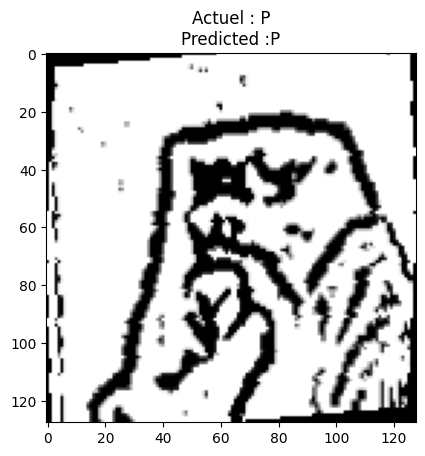

In [45]:
Path =os.path.join(image_dirs + '/P/0.jpg')
img =Image.open(Path)
# Apply the transform to the image
img = Transforms(img)
plt.imshow(img.permute(1, 2, 0), cmap ='gray')
img = img.to(device).unsqueeze(0)  # add batch dimension
print(img.shape)

# Pass the transformed image to the model
output = Model(img)
Max_val, label =torch.max(output.data, 1)
# Reverse the dictionary
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}

plt.title('Actuel : {}\nPredicted :{}'.format(Path.split('/')[-2],
                                       Labels_index[label.item()]))
plt.show()

In [46]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Get the GPU device
    device = torch.device("cuda")

    # Get the total and available memory in MB
    total_mem = torch.cuda.get_device_properties(device).total_memory / 1024**2
    free_mem = torch.cuda.memory_allocated(device) / 1024**2

    # Print the GPU memory usage
    print(f"GPU Total Memory: {total_mem:.2f} MB")
    print(f"GPU Used Memory: {free_mem:.2f} MB")
else:
    print("GPU is not available")

GPU Total Memory: 2002.69 MB
GPU Used Memory: 348.41 MB


In [47]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 356769 KiB | 634779 KiB |   6446 GiB |   6446 GiB |
|       from large pool | 348416 KiB | 633088 KiB |   6421 GiB |   6421 GiB |
|       from small pool |   8353 KiB |  15203 KiB |     24 GiB |     24 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 356769 KiB | 634779 KiB |   6446 GiB |   6446 GiB |
|       from large pool | 348416 KiB | 633088 KiB |   6421 GiB |